<a href="https://colab.research.google.com/github/phycoding/Animal_counting/blob/main/Animal_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 4.7 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=599c1c4ed878108eb63ead0e31e2ad753aebfd762b507e4f3c3a3a2409591117
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/d

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
import cv2
!rm -r frames/*
!mkdir frames/

#specify path to video
video = "/content/stock-footage-herd-of-wild-horses-roaming-freely-on-green-pasture-fps.webm"

#capture video
cap = cv2.VideoCapture(video)
cnt=0

# Check if video file is opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

ret,first_frame = cap.read()

#Read until video is completed
while(cap.isOpened()):
    
  # Capture frame-by-frame
  ret, frame = cap.read()
     
  if ret == True:

    #save each frame to folder        
    cv2.imwrite('frames/'+str(cnt)+'.png', frame)
    cnt=cnt+1
    if(cnt==750):
      break

  # Break the loop
  else: 
    break

rm: cannot remove 'frames/*': No such file or directory


In [ ]:
#frame rate of a video
FPS=cap.get(cv2.CAP_PROP_FPS)
print(FPS)

29.97


In [ ]:
cfg = get_cfg()

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_f97cb7.pkl: 136MB [00:04, 31.5MB/s]                           


In [ ]:
#read an image
img = cv2.imread("/content/frames/1.png")

#pass to the model
outputs = predictor(img)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


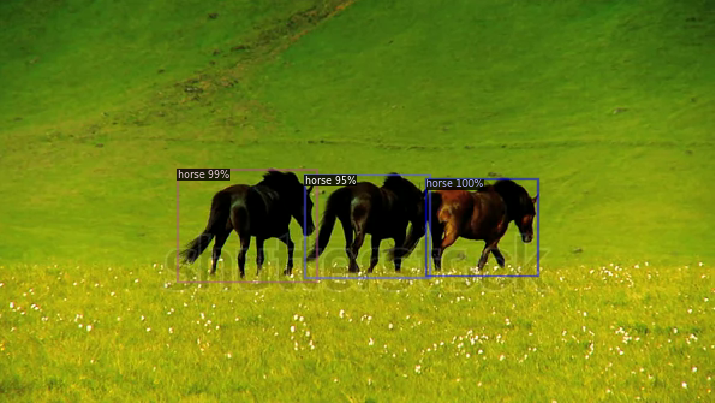

In [ ]:
# Use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
classes=outputs['instances'].pred_classes.cpu().numpy()
print(classes)

[17 17 17]


In [ ]:
print(outputs)

{'instances': Instances(num_instances=3, image_height=336, image_width=596, fields=[pred_boxes: Boxes(tensor([[355.2560, 149.5730, 447.9468, 230.2992],
        [148.0341, 141.7872, 264.1312, 234.8646],
        [254.1065, 146.3004, 358.6136, 231.4227]], device='cuda:0')), scores: tensor([0.9958, 0.9896, 0.9533], device='cuda:0'), pred_classes: tensor([17, 17, 17], device='cuda:0')])}


In [ ]:
bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()
print(bbox)

[[355.25604 149.573   447.9468  230.29916]
 [148.03415 141.78719 264.13116 234.86456]
 [254.10654 146.30035 358.61356 231.42268]]


In [ ]:
score = outputs['instances'].scores.cpu().numpy()

In [ ]:
score

array([0.99577016, 0.98963696, 0.95325285], dtype=float32)

In [ ]:
for i in bbox:
  print(i)

[355.25604 149.573   447.9468  230.29916]
[148.03415 141.78719 264.13116 234.86456]
[254.10654 146.30035 358.61356 231.42268]


In [ ]:
score.tolist()

[0.9957701563835144, 0.9896369576454163, 0.9532528519630432]

In [ ]:
def format(bbox,score):
  lst = []
  lst1 = bbox.tolist()
  lst2 = score.tolist()
  for (i,j) in zip(lst1,lst2):
    lst = lst+[i+[j]]
  return lst
  

In [ ]:
format(bbox,score)

[[355.25604248046875,
  149.572998046875,
  447.9468078613281,
  230.29916381835938,
  0.9957701563835144],
 [148.03414916992188,
  141.7871856689453,
  264.13116455078125,
  234.86456298828125,
  0.9896369576454163],
 [254.10653686523438,
  146.30035400390625,
  358.6135559082031,
  231.4226837158203,
  0.9532528519630432]]

In [ ]:
outputs['instances'].scores.cpu().numpy()

array([0.99577016, 0.98963696, 0.95325285], dtype=float32)

In [ ]:
for i in bbox:
  

In [ ]:
import matplotlib
matplotlib.use('TKAgg')

In [ ]:
!pip install filterpy
from sort import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


from: can't read /var/mail/sort


In [ ]:
mot_tracker1 = Sort(max_age=3, min_hits=1, iou_threshold=0.15)

In [ ]:
img = cv2.imread("/content/frames/1.png")
figs = out(img)

In [ ]:
figs

[[355.25604248046875,
  149.572998046875,
  447.9468078613281,
  230.29916381835938,
  0.9957701563835144],
 [148.03414916992188,
  141.7871856689453,
  264.13116455078125,
  234.86456298828125,
  0.9896369576454163],
 [254.10653686523438,
  146.30035400390625,
  358.6135559082031,
  231.4226837158203,
  0.9532528519630432]]

In [ ]:

track_bbs_ids = mot_tracker1.update(np.array(figs))

In [ ]:
import pandas as pd
pd.DataFrame(track_bbs_ids)

,0,1,2,3,4
0,254.106537,146.300354,358.613556,231.422684,3.0
1,148.034149,141.787186,264.131165,234.864563,2.0
2,355.256042,149.572998,447.946808,230.299164,1.0


In [ ]:
def out(img):
  outputs = predictor(img)
  bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()
  score = outputs['instances'].scores.cpu().numpy()
  return format(bbox,score)


In [ ]:
animal_dict = {15: u'cat',
 16: u'dog',
 17: u'horse',
 18: u'sheep',
 19: u'cow',
 20: u'elephant',
 21: u'bear',
 22: u'zebra',
 23: u'giraffe'}

#finding no of animal in a video.
#finding their stay time
def find_animal_time(img):
  outputs = predictor(img)
  classes = outputs['instances'].pred_classes.cpu().numpy()
  figs = out(img)
  track_bbs_ids = mot_tracker1.update(np.array(figs))
  return track_bbs_ids, classes
  

In [ ]:
# Function to run on video file and return results in dataframe.

def video_run(filepath):
  lst = []
  cap = cv2.VideoCapture(filepath)
  cnt=0

  # Check if video file is opened successfully
  if (cap.isOpened()== False): 
    print("Error opening video stream or file")

  ret,first_frame = cap.read()

#Read until video is completed
  while(cap.isOpened()):
    ret, frame = cap.read()
    for m in frame:
      ids, cls = find_animal_time(frame)
      for i,j in zip(ids,cls):
        
        lst = lst+[i.tolist()+[j]]
    
    if ret == True:

    #save each frame to folder        
      frame
      cnt=cnt+1
    

  # Break the loop
    else: 
      break
  #frame rate of a video
  FPS=cap.get(cv2.CAP_PROP_FPS)
  return pd.DataFrame(lst)



In [ ]:
#put the path of any videofile
file_name = "/content/stock-footage-herd-of-wild-horses-roaming-freely-on-green-pasture-fps.webm"


In [ ]:
df = video_run(file_name)

In [ ]:
df

,0,1,2,3,4,5
0,255.390766,145.727827,356.725607,231.775277,3.0,17
1,146.368969,142.734375,264.232275,234.479856,2.0,17
2,348.749601,150.250857,447.008133,231.383300,1.0,17
3,255.390265,145.727375,356.726162,231.775748,3.0,17
4,146.369055,142.734370,264.232331,234.479810,2.0,17
...,...,...,...,...,...,...
1003,146.370231,142.734552,264.232491,234.479147,2.0,17
1004,348.793846,150.283710,446.970925,231.348782,1.0,17
1005,255.377242,145.716156,356.739701,231.787155,3.0,17
1006,146.370231,142.734552,264.232491,234.479147,2.0,17


In [ ]:
#function to analyze the dataframe
def analyze_results(df):
  time = []
  cls = []
  count = df.groupby([4]).count()
  for i in count[0]:
    time = time+ [i/FPS]

  for i in range(1,len(count[0])+1):
    cls = cls + [animal_dict[df.loc[df[4]==i].head(1)[5].values.tolist()[0]]]
  
  return pd.DataFrame({"Id":count[0],"Time":time,"Class":cls})


In [ ]:
analyze_results(df)

,Id,Time,Class
4,,,
1.0,336,11.211211,horse
2.0,336,11.211211,horse
3.0,336,11.211211,horse
